In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koodikirjasto as kk
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Työn esittely

Data koostettu:
Suurin osa täältä
https://www.avoindata.fi/data/fi/dataset/ajoneuvojen-avoin-data/resource/00041d67-966e-48cf-a720-255faf09d55c?
rekisteroinnitmalleittan taulu koostettu näistä datoista
https://www.aut.fi/tilastot/ensirekisteroinnit/henkiloautojen_vuosittaiset_merkki-_ja_mallitilastot

Data koostettiin useammasta lähteestä, koska pääasiallisen datalähteen data oli puutteellista vuodesta 2017 lähtien. 


TJTS490 Tietokantajärjestelmät ja data-analytiikka
Harjoitustyö
Susanna Lähde & Aatu Laitinen

Tässä työssä tutkitaan ajoneuvorekisterin dataa. 
Katsotaan millaista tietoa data pitää sisällään:

Ajatellaan, että olemme autojen jälleenmyyjä ja vaihtoautokauppa. Toimimme Suomen suurimmissa kaupunkikeskuksissa.
Meidän liiketoiminnan jatkuuvuden kannalta tärkeimmät tutkimushypoteesit voisivat olla:
1. Markkinatrendit
2. Alueelliset erot
3. ..?

# Data exploration

tähän jotain data explorationia jeejee
esim tutkitaan että millaisia arvoja kolumnit sisältää, onko nulleja (ja pohditaan mihin ne vaikuttaa) yms yms

# Markkinatrendit
Tutkitaan ensin markkinatrendejä
Käsitellään tässä muutamia tutkimushypoteeseja
1. jotain hybrideistä..?

In [9]:
df = kk.hybridiautot_luokittain('M1', 2012, 2016)

<connection object at 0x000001D101D06DF0; dsn: 'user=postgres password=xxx dbname=VehicleRegisterDatabase host=192.168.0.15', closed: 0>
Cursor created successfully


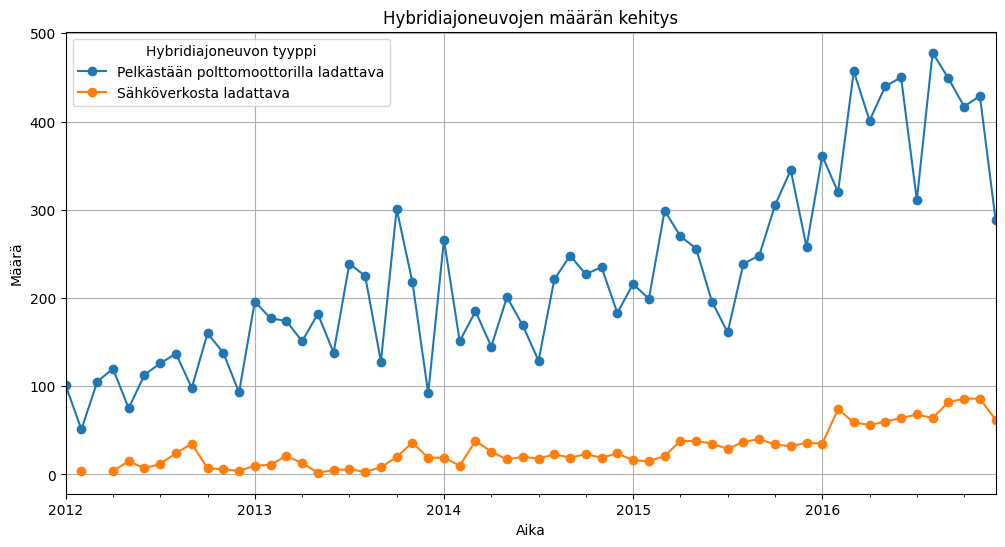

In [10]:
df['date'] = pd.to_datetime(df['vuosi'].astype(str) + '-' + df['kuukausi'].astype(str), format='%Y-%m')
condition = df['hybridityyppi'] == 'Ei määritelty'
df = df[~condition]
df_pivot = df.pivot(index='date', columns='hybridityyppi', values='maara')

fig, ax = plt.subplots(figsize=(12, 6))
df_pivot.plot(ax=ax, marker='o')
plt.title('Hybridiajoneuvojen määrän kehitys')
plt.xlabel('Aika')
plt.ylabel('Määrä')
plt.legend(title='Hybridiajoneuvon tyyppi')
plt.grid(True)
plt.show()


hybridityyppi  Pelkästään polttomoottorilla ladattava  Sähköverkosta ladattava
date                                                                          
2012-01-01                                      101.0                      NaN
2012-02-01                                       51.0                      4.0
2012-03-01                                      105.0                      NaN
2012-04-01                                      120.0                      4.0
2012-05-01                                       75.0                     15.0
2012-06-01                                      113.0                      7.0
2012-07-01                                      126.0                     12.0
2012-08-01                                      137.0                     24.0
2012-09-01                                       98.0                     35.0
2012-10-01                                      160.0                      7.0
2012-11-01                                      138.

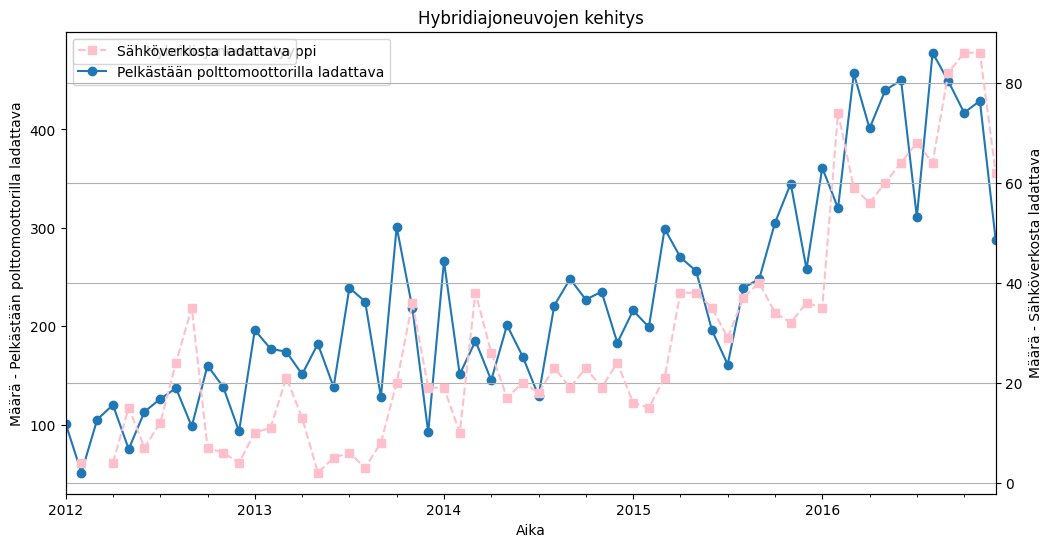

In [11]:
df['date'] = pd.to_datetime(df['vuosi'].astype(str) + '-' + df['kuukausi'].astype(str), format='%Y-%m')
condition = df['hybridityyppi'] == 'Ei määritelty'
df = df[~condition]
df_pivot = df.pivot(index='date', columns='hybridityyppi', values='maara')
print(df_pivot)
fig, ax1 = plt.subplots(figsize=(12, 6))

df_pivot.plot(ax=ax1, y='Pelkästään polttomoottorilla ladattava', marker='o', label='Pelkästään polttomoottorilla ladattava')
ax1.set_title('Hybridiajoneuvojen kehitys')
ax1.set_xlabel('Aika')
ax1.set_ylabel('Määrä - Pelkästään polttomoottorilla ladattava')
ax1.legend(title='Hybridiajoneuvon tyyppi')

ax2 = ax1.twinx()
ax2.set_ylabel('Määrä - Sähköverkosta ladattava')  # Replace with your second y-axis label


df_pivot.plot(ax=ax2, y='Sähköverkosta ladattava', marker='s', linestyle='--', label='Sähköverkosta ladattava', color="pink")
plt.grid(True)
plt.show()

In [17]:
df = kk.ensirekisteroinnit_vuosittain(2017, 2022, 'merkki')

<connection object at 0x000001D10CDB6CE0; dsn: 'user=postgres password=xxx dbname=VehicleRegisterDatabase host=192.168.0.15', closed: 0>
Cursor created successfully


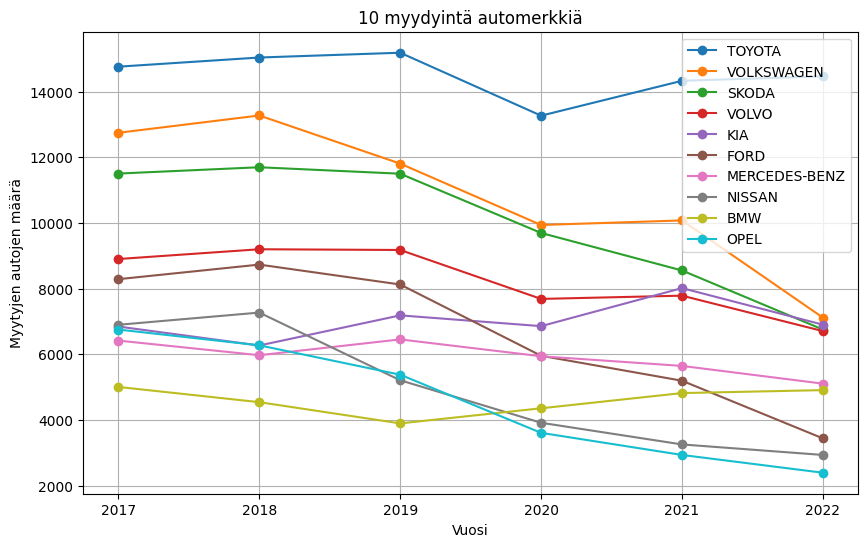

In [18]:
df['Total'] = df[df.columns[1:]].sum(axis=1)
df_sorted = df.sort_values(by='Total', ascending=False).head(10)
plt.figure(figsize=(10, 6))
for index, row in df_sorted.iterrows():
    plt.plot(df.columns[1:-1], row[1:-1], marker='o', label=row['merkki'])
plt.title('10 myydyintä automerkkiä')
plt.xlabel('Vuosi')
plt.ylabel('Myytyjen autojen määrä')
plt.legend()
plt.grid(True)
plt.show()

Visualisoidaan myös suhteellista muutosta, jolloin on helpompi nähdä yksittäisten merkkien trendit

In [19]:
df_sorted
merkit = df_sorted["merkki"].values

df_pc_changes = df_sorted.drop(columns=["merkki", "Total"]).transpose().pct_change() * 100

df_pc_changes = df_pc_changes.transpose()
df_pc_changes["merkki"]= merkit

print(df_pc_changes)


    2017      2018       2019       2020       2021       2022         merkki
75   NaN  1.890372   0.970874 -12.625132   8.004824   0.949124         TOYOTA
78   NaN  4.134630 -11.037444 -15.828252   1.398531 -29.370907     VOLKSWAGEN
66   NaN  1.668840  -1.684193 -15.686957 -11.778053 -21.031097          SKODA
79   NaN  3.335954  -0.239130 -16.234474   1.287721 -13.856427          VOLVO
37   NaN -8.427048  14.625199  -4.563796  16.882928 -13.895472            KIA
26   NaN  5.356497  -6.939196 -26.701120 -12.758100 -33.788724           FORD
50   NaN -6.932544   8.051557  -7.947328  -4.947829  -9.560907  MERCEDES-BENZ
56   NaN  5.391304 -28.341584 -24.832086 -16.849630  -9.824992         NISSAN
5    NaN -9.265176 -14.216549  11.800924  10.624140   1.866833            BMW
57   NaN -7.105848 -14.247012 -32.912098 -18.642659 -18.420157           OPEL


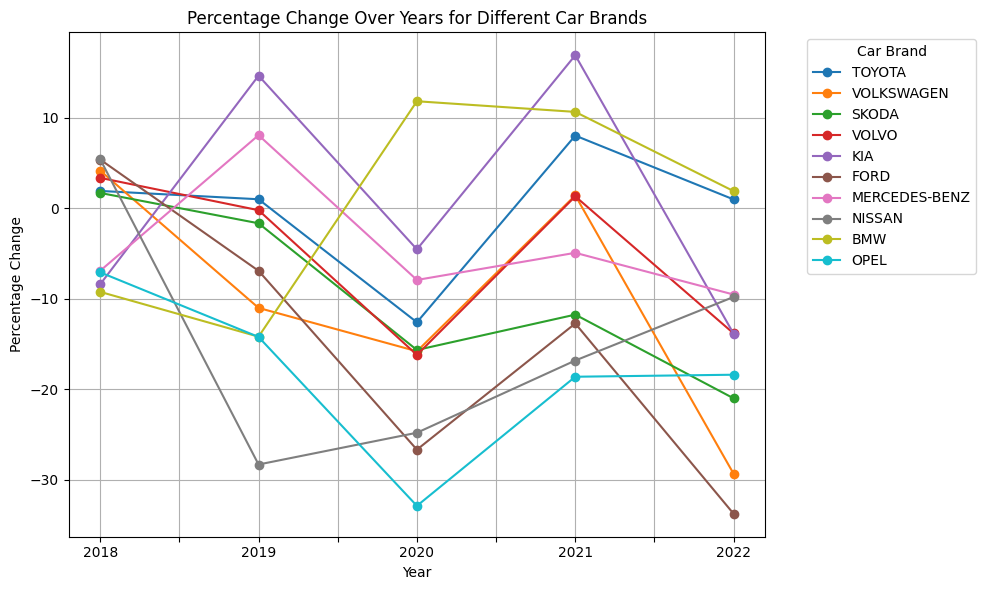

In [20]:
# Set the 'merkki' column as the index (assuming it represents the categories)
df_pc_changes.set_index('merkki', inplace=True)

# Transpose the DataFrame for easier plotting
df_transposed = df_pc_changes.transpose()

# Plot the data
plt.figure(figsize=(10, 6))
df_transposed.plot(marker='o', linestyle='-', ax=plt.gca())
plt.title('Percentage Change Over Years for Different Car Brands')
plt.xlabel('Year')
plt.ylabel('Percentage Change')
plt.legend(title='Car Brand', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
df = kk.ensirekisteroinnit_vuosittain(2017, 2022, 'merkki')

df = df[df["merkki"] == "VOLVO"]
print(df)
df.drop(columns="merkki",inplace=True) # Toisaalta tän vois tehdä sillä vanhalla datalla ja sit tällä datalla katsoa, miten todellisuudessa meni
print(df)

<connection object at 0x000001D10CDB7780; dsn: 'user=postgres password=xxx dbname=VehicleRegisterDatabase host=192.168.0.15', closed: 0>
Cursor created successfully
   merkki  2017  2018  2019  2020  2021  2022
79  VOLVO  8903  9200  9178  7688  7787  6708
    2017  2018  2019  2020  2021  2022
79  8903  9200  9178  7688  7787  6708


In [28]:
df = df.transpose()
df
df["määrä"] = df[79]
df

,79,määrä
2017,8903,8903
2018,9200,9200
2019,9178,9178
2020,7688,7688
2021,7787,7787
2022,6708,6708


<Axes: >

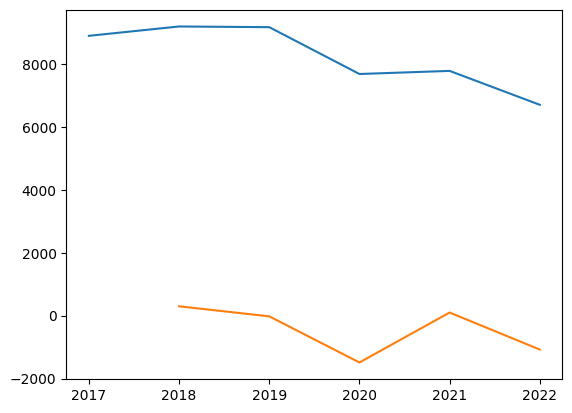

In [29]:
df["määrä"].plot()
df['erotus'] = df['määrä'].diff()
df['erotus'].plot()

# Alueelliset erot

In [2]:
df = kk.ensirekisteroinnit_kunnittain_ajoneuvoluokassa("01.01.2010", "01.01.2016", "M1", "Helsinki",False)
df = df.iloc[:15]


<connection object at 0x000001E51AA168A0; dsn: 'user=postgres password=xxx dbname=VehicleRegisterDatabase host=192.168.0.15', closed: 0>
Cursor created successfully


<Figure size 1500x800 with 0 Axes>

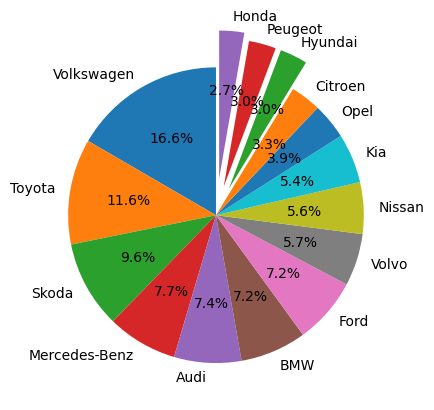

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))

# Create a pie chart with exploded slices
explode = (0, 0, 0, 0, 0, 0, 0, 0,0 ,0, 0, 0, 0.2, 0.2 ,0.25)  # Adjust the explode values as needed
fig, ax = plt.subplots()
ax.pie(df["Määrä"], labels=df["Merkki"].values, autopct='%1.1f%%', startangle=90, explode=explode)


#ax.set_title('Ajoneuvoluokkien osuudet')

plt.show()


<connection object at 0x000001E51AA168A0; dsn: 'user=postgres password=xxx dbname=VehicleRegisterDatabase host=192.168.0.15', closed: 0>
Cursor created successfully


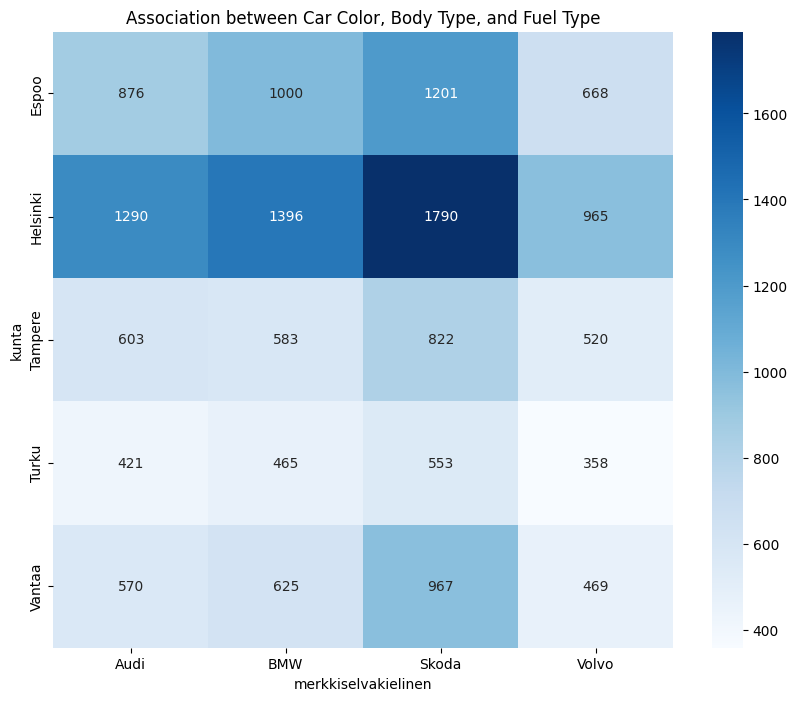

In [7]:
df = kk.rekisteroityjen_autojen_tiedot_aikavalilla(2015, 2016)
df.head()

plt.figure(figsize=(10, 8))

selected_kunta_values = ["Helsinki", "Espoo", "Vantaa", "Tampere", "Turku"]  # Add the specific values you want to include
df_filtered = df[df["kunta"].isin(selected_kunta_values)]

selected_merkki_values = ["BMW", "Volvo", "Audi", "Skoda"]  # Add the specific values you want to include
df_filtered = df_filtered[df_filtered["merkkiselvakielinen"].isin(selected_merkki_values)]


# Example for the heatmap of associations between 'vari', 'korityyppi', and 'kayttovoima'
associations = pd.crosstab(index=df_filtered['kunta'], columns=[df_filtered['merkkiselvakielinen']])
sns.heatmap(associations, cmap='Blues', annot=True, fmt='d')
plt.title('Association between Car Color, Body Type, and Fuel Type')
plt.show()

# Ostoskorianalyysi

In [ ]:
# Import necessary libraries
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# Sample data (replace this with your own dataset)
data = {
    'TransactionID': [1, 1, 2, 2, 2, 3, 3, 3, 3, 4],
    'Item': ['A', 'B', 'A', 'C', 'D', 'B', 'C', 'D', 'E', 'A']
}

df1 = pd.DataFrame(data)
df1

In [ ]:


# Convert the data into a one-hot encoded matrix
basket = pd.crosstab(df.columns, dropna=False)

# Apply the Apriori algorithm to find frequent itemsets
frequent_itemsets = apriori(basket, min_support=0.2, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)

# Display the results
print("Frequent Itemsets:")
print(frequent_itemsets)

print("\nAssociation Rules:")
print(rules)


In [ ]:
df = kk.rekisteroityjen_autojen_tiedot_aikavalilla(2015, 2016)
df.head()

In [ ]:
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# Load your dataset
# Assuming your dataset is stored in a DataFrame named 'df'
# Replace 'your_dataset.csv' with the actual path or filename
# df = pd.read_csv('your_dataset.csv')

# Drop unnecessary columns for this analysis (e.g., 'kunta' and 'matkamittarilukema')
df = df.drop(['ahdin', 'sahkohybridi', 'matkamittarilukema', 'vari', 'suurinnettoteho', 'sylintereidenlkm', 'vaihteistotyyppi', 'istumapaikkojenlkm', 'ohjaamotyyppi', 'vaihteidenlkm'], axis=1)
#print(df) # Ton sähköhybridin valuet vois myös muuttaa nii että true on sähkö nii ois helpompi tajuta sit tässä ostokorissa
# Convert categorical variables into dummy/indicator variables
df_encoded = pd.get_dummies(df, prefix='', prefix_sep='')

# Apply Apriori algorithm to find frequent itemsets
frequent_itemsets = apriori(df_encoded, min_support=0.01, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

# Display the frequent itemsets and association rules
print("Frequent Itemsets:")
print(frequent_itemsets)

print("\nAssociation Rules:")
print(rules)


In [ ]:
frequent_itemsets.head(10)

In [ ]:
# Assuming 'frequent_itemsets' is your frequent itemsets DataFrame
larger_itemsets = frequent_itemsets[frequent_itemsets['itemsets'].apply(lambda x: len(x) > 1)]
larger_itemsets = larger_itemsets.sort_values(by='support', ascending=False)

# Display the top frequent itemsets with more than one item
print(larger_itemsets.head(10))


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Assuming 'rules' is your association rules DataFrame
G = nx.DiGraph()

for _, row in rules.iterrows():
    G.add_edge(tuple(row['antecedents']), tuple(row['consequents']),
               support=row['support'], confidence=row['confidence'])

pos = nx.spring_layout(G)
labels = {(i, j): f"Supp: {d['support']:.2f}\nConf: {d['confidence']:.2f}" 
          for i, j, d in G.edges(data=True)}

nx.draw(G, pos, with_labels=True, node_size=700, node_color="skyblue", font_size=8)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_color='red')
plt.show()


In [ ]:
df.head()

In [8]:
# Voisiko tässä olla hypoteesi jotenkin niin, että kuntien välillä ei ole eroa tms tai sitten katsoa kahta kuntaa esim

import pandas as pd
from scipy.stats import chi2_contingency

# Assuming 'your_categorical_variable1' and 'your_categorical_variable2' are categorical variables
# Replace them with the actual column names from your dataset
crosstab = pd.crosstab(df['kunta'], df['merkkiselvakielinen'])

# Perform chi-squared test for independence
chi2, p, _, _ = chi2_contingency(crosstab)

# Print the results
print(f"Chi-squared value: {chi2}")
print(f"P-value: {p}")


Chi-squared value: 98196.48868019377
P-value: 0.0


# Sekalaista

In [ ]:
df = pd.read_csv('Ajoneuvojen_avoin_data_5_21.csv', encoding='ISO-8859-1', on_bad_lines="skip", delimiter=";",low_memory=False)

Otetaan dataa 2010 luvulta eteenpäin

In [ ]:
df['ensirekisterointipvm'] = pd.to_datetime(df['ensirekisterointipvm'])
df = df[df['ensirekisterointipvm'] > '2010-01-01']

Otetaan pelkästään M1 ajoneuvoluokan arvot eli henkilöautot

In [ ]:
df = df[df['ajoneuvoluokka'] == 'M1']

In [ ]:
df

In [ ]:
value_counts_series = df['merkkiSelvakielinen'].dropna().value_counts()
values_to_keep = value_counts_series[value_counts_series > 30000].index
df = df[df['merkkiSelvakielinen'].isin(values_to_keep)]

In [ ]:
df['merkkiSelvakielinen'].dropna().nunique()

In [ ]:
df['merkkiSelvakielinen'].dropna().value_counts()

In [ ]:
plt.figure(figsize=(20, 8))
value_counts = df['merkkiSelvakielinen'].value_counts()
plt.bar(value_counts.index, value_counts.values)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Amount of registered vehicles for every brand with over 30 000 registered vehicles')
plt.show()

In [ ]:

brand_df = df[df['merkkiSelvakielinen'] == 'Volvo']
brand_df['Year'] = (brand_df['ensirekisterointipvm']).dt.year
brand_counts = brand_df.groupby('Year').size()
# Plot the trend
plt.figure(figsize=(10, 6))
plt.plot(brand_counts.index, brand_counts.values, marker='o', linestyle='-')
plt.title('First Registrations for Volvo per year')
plt.xlabel('Year')
plt.ylabel('Number of Registrations')
plt.grid(True)
plt.show()